# Generate Push Object URDFs

In [144]:
import alphashape
import math
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from shapely.geometry import Point

def load_vertices(obj_file):
    vertices = []
    with open(obj_file, "r") as file:
        for line in file:
            if not line.startswith("v "):
                continue
            vertices.append(np.array(list(map(float, re.findall("[-]?\d+\.\d+", line)))))
    return np.array(vertices)

def visualize(vertices):
    plt.scatter(vertices[:,0], vertices[:,1], c='black', s=1)
    plt.axis("equal")
    plt.grid()
    
def generate_collision_points(vertices, resolution = 0.01, alpha = 0, title = ""):
    min_x = np.min(vertices[:, 0])
    max_x = np.max(vertices[:, 0])
    min_y = np.min(vertices[:, 1])
    max_y = np.max(vertices[:, 1])
    min_z = np.min(vertices[:, 2])
    max_z = np.max(vertices[:, 2])
        
    def round_r(v):
        return math.floor(v / resolution) * resolution
    
    center_z = 0.5 * (min_z + max_z)
    diameter_z = max_z - min_z
    
    plt.figure(figsize=(8,8))
    visualize(vertices)
    
    
    # duplicate vertices and scale inside to improve alpha shape result
    vertices = np.concatenate([vertices, vertices * 0.7])
    # generate alpha shape (concave hull)
    alpha_shape = alphashape.alphashape(vertices[:, :2], alpha)
    plt.gca().add_patch(PolygonPatch(alpha_shape, alpha=0.2))

    collision_points = []
    for x in np.arange(start=round_r(min_x) - resolution, stop=round_r(max_x) + resolution, step=resolution):
        for y in np.arange(start=round_r(min_y) - resolution, stop=round_r(max_y) + resolution, step=resolution):
            p = Point(x, y)
            if p.within(alpha_shape):
                plt.scatter([x], [y], c="r", s=2)
                collision_points.append(np.array([x, y, min_z]))
    plt.axis("equal")
    plt.grid()
    plt.title(title)
    return collision_points, alpha_shape

def generate_urdf(folder_name, obj_file, urdf_file, mass = 0.5, moment = 0.002, resolution = 0.01, alpha = 0):
    vertices = load_vertices(os.path.join(folder_name, obj_file))
    collision_points, boundary = generate_collision_points(vertices, resolution, alpha, title = obj_file)
    
    # filter out duplicates
    unique_ext = set()
    exterior = []
    for coords in boundary.exterior.coords:
        if coords in unique_ext:
            continue
        exterior.append(coords)
        unique_ext.add(coords)
    exterior = np.array(exterior)
    np.save(os.path.join(folder_name, urdf_file[:-5] + "_ext.npy"), exterior)
    
    min_z = np.min(vertices[:, 2])
    max_z = np.max(vertices[:, 2])
    diameter_z = max_z - min_z
    
    collision_urdf = ""
    for cp in collision_points:
        collision_urdf += """
    <collision>
      <origin rpy="0 0 0" xyz="%.4f %.4f %.4f"/>
      <geometry>
        <sphere radius="%.4f"/>
      </geometry>
    </collision>
        """ % (cp[0], cp[1], cp[2], diameter_z * 0.51)
    
    
    
    
#     collision_urdf = ""
    
    
    

    urdf = """<?xml version="1.0" ?>
<robot name="push_object">
  <link name="link_x">
    <inertial>
      <mass value="0"/>
      <inertia ixx="1.0" ixy="0.0" ixz="0.0" iyy="1.0" iyz="0.0" izz="1.0"/>
    </inertial>
  </link>

  <link name="link_y">
    <inertial>
      <mass value="0"/>
      <inertia ixx="1.0" ixy="0.0" ixz="0.0" iyy="1.0" iyz="0.0" izz="1.0"/>
    </inertial>
  </link>
  
  <link name="link_z">
    <inertial>
      <mass value="0"/>
      <inertia ixx="1.0" ixy="0.0" ixz="0.0" iyy="1.0" iyz="0.0" izz="1.0"/>
    </inertial>
  </link>
  
  <link name="link_yaw">
    <inertial>
      <mass value="0"/>
      <inertia ixx="1.0" ixy="0.0" ixz="0.0" iyy="1.0" iyz="0.0" izz="1.0"/>
    </inertial>
  </link>

  <link name="link_object">
    <contact>
      <rolling_friction value="0.03"/>
      <spinning_friction value="0.03"/>
    </contact>

    <inertial>
      <origin rpy="0 0 0" xyz="0 0 0"/>
       <mass value="%.6f"/>
       <inertia ixx="1" ixy="0" ixz="0" iyy="1" iyz="0" izz="%.6f"/>
    </inertial>
    <visual>
      <origin rpy="0 0 0" xyz="0 0 %.6f"/>
      <geometry>
        <mesh filename="%s" scale="1.0 1.0 1.0"/>      
      </geometry>
      <material name="gray">
        <color rgba="0.5 0.5 0.5 1"/>
        <specular rgb="1 1 1"/>
      </material>
    </visual>
    %s
  </link>
  
  <joint name="joint_x" type="prismatic">
    <axis xyz="1 0 0"/>
    <origin xyz="0.0 0.0 0"/>
    <parent link="link_x"/>
    <child link="link_y"/>
    <limit effort="1000.0" lower="-15" upper="15" velocity="5"/>
  </joint>

  <joint name="joint_y" type="prismatic">
    <axis xyz="0 1 0"/>
    <origin xyz="0.0 0.0 0"/>
    <parent link="link_y"/>
    <child link="link_z"/>
    <limit effort="1000.0" lower="-15" upper="15" velocity="5"/>
  </joint>

  <joint name="joint_z" type="prismatic">
    <axis xyz="0 0 1"/>
    <origin xyz="0.0 0.0 0"/>
    <parent link="link_z"/>
    <child link="link_yaw"/>
    <limit effort="1000.0" lower="-15" upper="15" velocity="5"/>
  </joint>

  <joint name="joint_yaw" type="continuous">
    <axis xyz="0 0 1"/>
    <origin xyz="0.0 0.0 0"/>
    <parent link="link_yaw"/>
    <child link="link_object"/>
  </joint>
</robot>
""" % (-min_z, mass, moment, obj_file, collision_urdf)

    with open(os.path.join(folder, urdf_file), "w") as file:
        file.write(urdf)

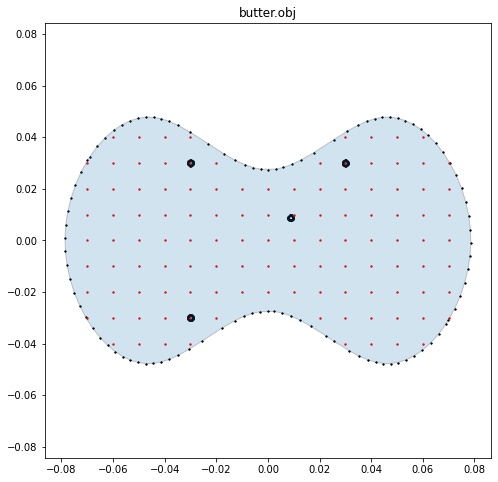

In [149]:
folder = "/home/eric/tiny-differentiable-simulator/data/mit-push/obj"
obj_file = "butter.obj"
urdf_file = "butter.urdf"
generate_urdf(folder, obj_file, urdf_file, mass = 1.197, moment = 0.00295, resolution = 0.01, alpha = 50)

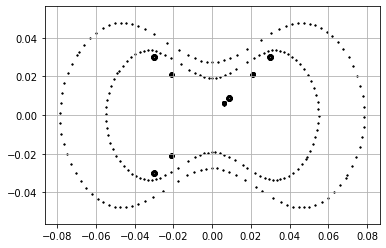

In [146]:
vertices = load_vertices(os.path.join(folder,obj_file))
vertices = np.concatenate([vertices, vertices * 0.7])
visualize(vertices)

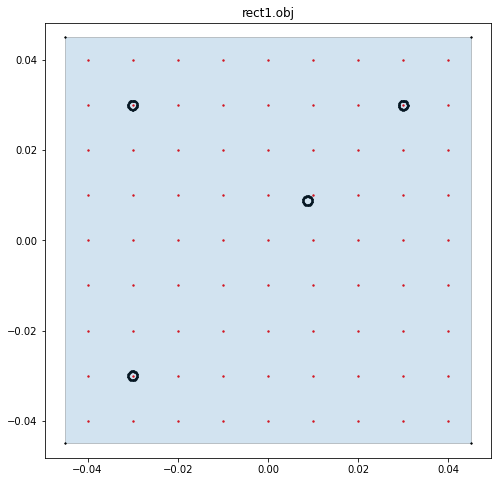

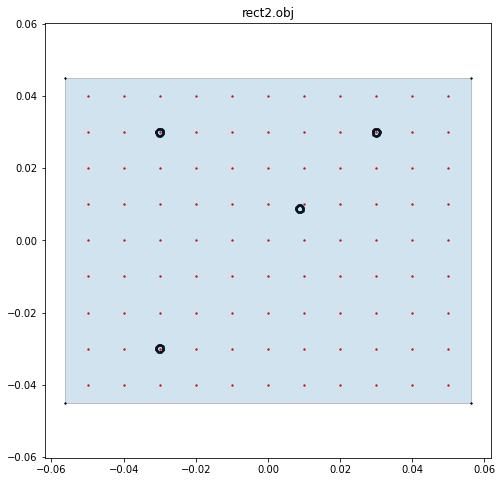

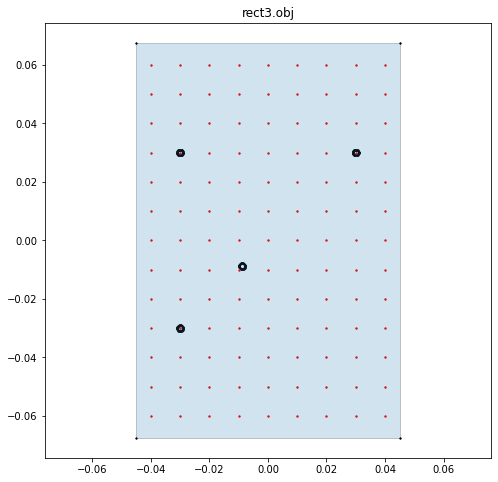

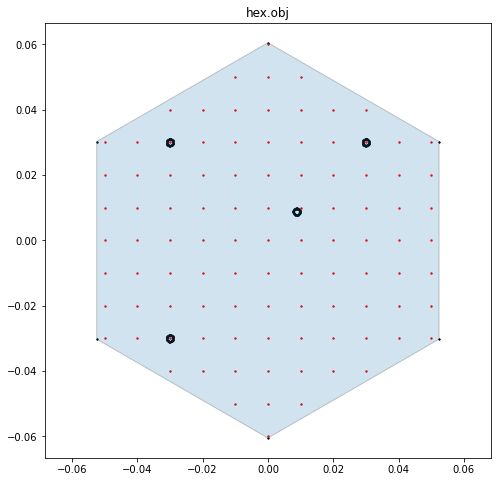

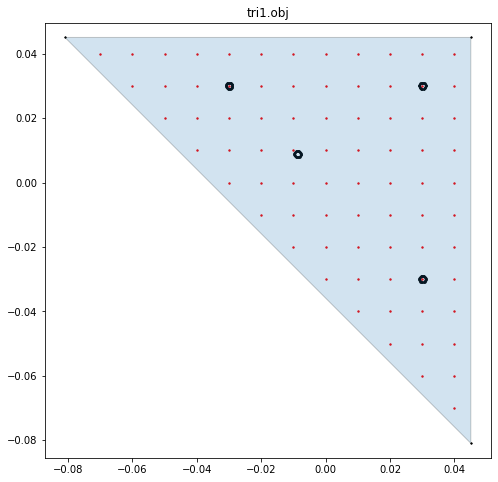

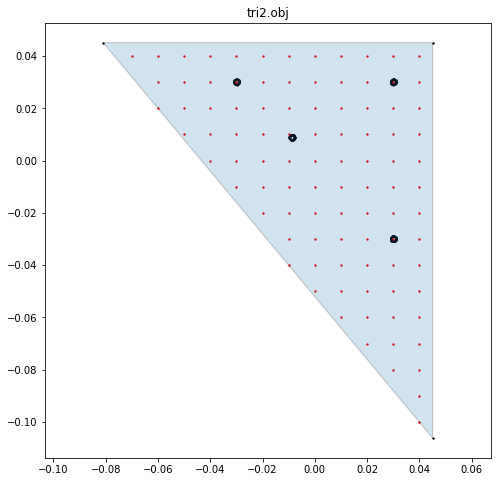

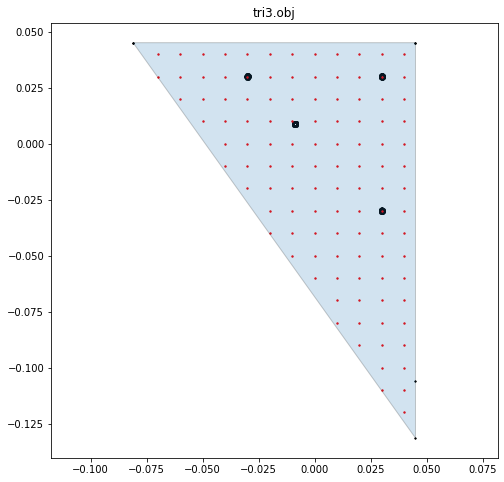

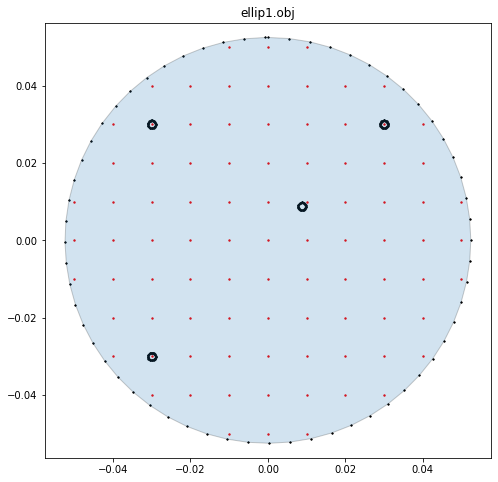

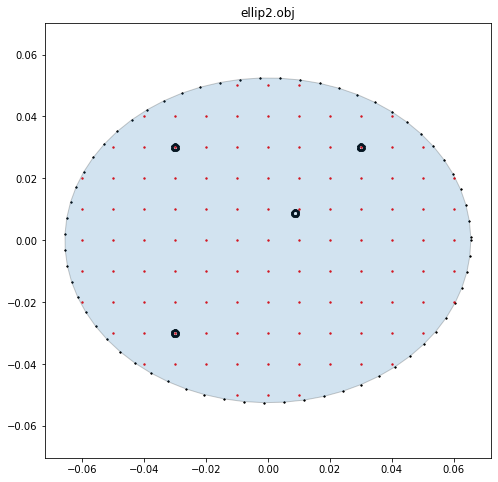

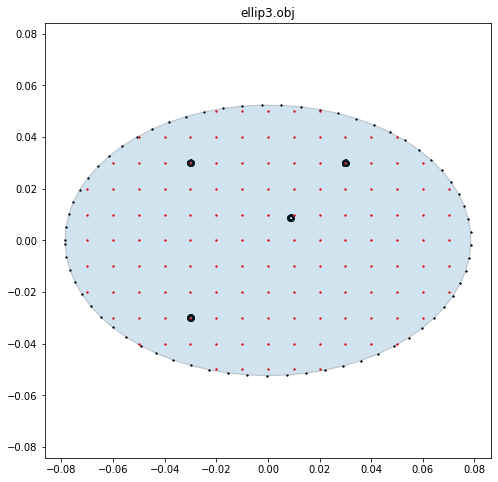

In [147]:
masses = {
    "rect1": 0.837,
    "rect2": 1.045,
    "rect3": 1.251,
    "hex": 0.983,
    "tri1": 0.803,
    "tri2": 0.983,
    "tri3": 1.133,
    "ellip1": 0.894,
    "ellip2": 1.110,
    "ellip3": 1.334
}

moments = {
    "rect1": 0.00113,
    "rect2": 0.00181,
    "rect3": 0.00274,
    "hex": 0.0015,
    "tri1": 0.00141,
    "tri2": 0.00211,
    "tri3": 0.00296,
    "ellip1": 0.00123,
    "ellip2": 0.00195,
    "ellip3": 0.00295
}

for obj in ("rect1", "rect2", "rect3", "hex", "tri1", "tri2", "tri3", "ellip1", "ellip2", "ellip3"):
    generate_urdf(folder, obj + ".obj", obj + ".urdf", mass = masses[obj], moment = moments[obj], resolution = 0.01, alpha = 0)  # just convex hull is sufficient

Just to make sure the exterior points are in the right order so that they form a contiguous array of lines that we can use for collision checking...

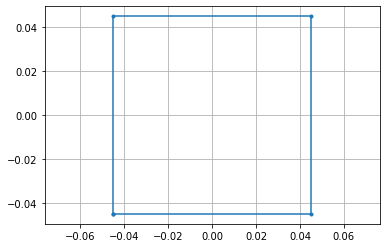

In [131]:
exterior = np.load(os.path.join(folder, "rect1_ext.npy"))
plt.plot(np.concatenate([exterior[:,0], [exterior[0,0]]]),
         np.concatenate([exterior[:,1], [exterior[0,1]]]), '.-')
plt.axis("equal")
plt.grid()

In [129]:
print("\n".join([str(exterior[i,:]) for i in range(exterior.shape[0])]));

[-0.045 -0.045]
[-0.045  0.045]
[0.045 0.045]
[ 0.045 -0.045]


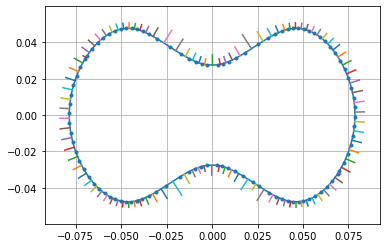

In [134]:
exterior = np.load(os.path.join(folder, "butter_ext.npy"))
plt.plot(np.concatenate([exterior[:,0], [exterior[0,0]]]),
         np.concatenate([exterior[:,1], [exterior[0,1]]]), '.-')
for i in range(exterior.shape[0]):
    left_i = i
    right_i = (i + 1) % exterior.shape[0]
    nx = exterior[left_i,1] - exterior[right_i,1]
    ny = -(exterior[left_i,0] - exterior[right_i,0])
    cx = 0.5 * (exterior[left_i,0] + exterior[right_i,0])
    cy = 0.5 * (exterior[left_i,1] + exterior[right_i,1])
    plt.plot([cx, cx + nx], [cy, cy + ny])
plt.axis("equal")
plt.grid()